<a href="https://colab.research.google.com/github/sajad-naderzadeh/ML/blob/main/Artificial_intelligence_for_accountability_and_banking_complaints_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24

In [ ]:
import pandas as pd
df = pd.read_excel("/content/data_output.xlsx")
id_list = df['id'].tolist()
answers_list = df['answers'].tolist()
questions_list = df['questions'].tolist()
topics_list = df['topic'].tolist()

In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict
import numpy as np

# Assume you have a DataFrame named df with 'answers' and 'questions' columns
data = {
    'id' : id_list,
    'dialogue': questions_list,
    'summary': answers_list,
    'topic' : topics_list
}
df = pd.DataFrame(data)

# Split the DataFrame into train, validation, and test sets
train_df = df.sample(frac=0.8, random_state=42)
temp_df = df.drop(train_df.index)
validation_df = temp_df.sample(frac=0.5, random_state=42)
test_df = temp_df.drop(validation_df.index)

# Convert DataFrames to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df[['id', 'dialogue', 'summary', 'topic']])
validation_dataset = Dataset.from_pandas(validation_df[['id', 'dialogue', 'summary', 'topic']])
test_dataset = Dataset.from_pandas(test_df[['id', 'dialogue', 'summary', 'topic']])

# Combine into a DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset
})

for split in ['train', 'validation', 'test']:
    if '__index_level_0__' in dataset_dict[split].features:
        dataset_dict[split] = dataset_dict[split].remove_columns('__index_level_0__')
print(dataset_dict)

# Step 4: Verify Dataset Features
print("Features after processing:")
print(f"Train: {dataset_dict['train'][0]}")
print(f"Validation: {dataset_dict['validation'][0]}")
print(f"Test: {dataset_dict['test'][0]}")


DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1899
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 238
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 237
    })
})
Features after processing:
Train: {'id': 2252, 'dialogue': 'About Hours on September: Referring to the branch and receiving the turn of the branch and responding only one (number) by raising this issue with the branch officer while responding to the disrespectful and expressing the "same" position.Bank image with customers seemed to be deliberately due to the offensive behavior of the branch responsible and ignoring the Charter of Honor Customer Bank Mellat Bank I request a change of branch and thanks to the answer to that respected authority and, if necessary, follow up at higher levels.Be', 'summary': 'Greetings and respect, please follow the i

In [ ]:
!pip install --upgrade pip
!pip install --disable-pip-version-check \
    torch==1.13.1 \
    torchdata==0.5.1 --quiet

!pip install \
    transformers==4.27.2 \
    datasets==2.11.0 \
    evaluate==0.4.0 \
    rouge_score==0.1.2 \
    loralib==0.1.1 \
    peft==0.3.0 --quiet

from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch
import time
import evaluate
import pandas as pd
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.3.0+cu121 requires torch==2.3.0, but you have torch 1.13.1 which is incompatible.
torchtext 0.18.0 requires torc

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
dataset = dataset_dict

model_name='google/flan-t5-base'

original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [ ]:
# class CustomTrainer(Trainer):
#     def create_scheduler(self, num_training_steps: int):
#         # Create a learning rate scheduler
#         self.lr_scheduler = get_linear_schedule_with_warmup(
#             self.optimizer,
#             num_warmup_steps=self.args.warmup_steps,
#             num_training_steps=num_training_steps
#         )
#         return self.lr_scheduler


In [ ]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"
print(print_number_of_trainable_model_parameters(original_model))

index = 200

dialogue = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary:
"""

inputs = tokenizer(prompt, return_tensors='pt')
output = tokenizer.decode(
    original_model.generate(
        inputs["input_ids"].to(device),
        max_new_tokens=200,
    )[0],
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

def tokenize_function(example):
    start_prompt = 'Summarize the following conversation.\n\n'
    end_prompt = '\n\nSummary: '
    prompt = [start_prompt + dialogue + end_prompt for dialogue in example["dialogue"]]
    example['input_ids'] = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt").input_ids
    example['labels'] = tokenizer(example["summary"], padding="max_length", truncation=True, return_tensors="pt").input_ids

    return example

# The dataset actually contains 3 diff splits: train, validation, test.
# The tokenize_function code is handling all data across all splits in batches.
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['id', 'topic', 'dialogue', 'summary',])

tokenized_datasets = tokenized_datasets.filter(lambda example, index: index % 100 == 0, with_indices=True)

print(f"Shapes of the datasets:")
print(f"Training: {tokenized_datasets['train'].shape}")
print(f"Validation: {tokenized_datasets['validation'].shape}")
print(f"Test: {tokenized_datasets['test'].shape}")

print(tokenized_datasets)

output_dir = f'./dialogue-summary-training-{str(int(time.time()))}'

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=1e-3,
    num_train_epochs=150,
    weight_decay=0.001,
    logging_steps=1,
    per_device_train_batch_size=5,  # Set the training batch size
    per_device_eval_batch_size=5,

    # load_best_model_at_end=True,  # Enable to load the best model when training ends
    # metric_for_best_model="eval_loss",  # Metric to use for best model selection
    # greater_is_better=False,  # Whether the metric should be maximized (False for loss, True for accuracy)
    # early_stopping_patience=3,  # Number of evaluations with no improvement before stopping


)

trainer = Trainer(
    model=original_model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation']
)

# trainer.train()



trainer.train()

# !aws s3 cp --recursive s3://dlai-generative-ai/models/flan-dialogue-summary-checkpoint/ ./flan-dialogue-summary-checkpoint/
# !ls -alh ./flan-dialogue-summary-checkpoint/pytorch_model.bin
# instruct_model = AutoModelForSeq2SeqLM.from_pretrained("./flan-dialogue-summary-checkpoint", torch_dtype=torch.bfloat16)

index = 200
dialogue = dataset['test'][index]['dialogue']
human_baseline_summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary:
"""

input_ids = tokenizer(prompt, return_tensors="pt").input_ids

original_model_outputs = original_model.generate(input_ids=input_ids.to(device), generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

# instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
# instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{human_baseline_summary}')
print(dash_line)
# print(f'ORIGINAL MODEL:\n{original_model_text_output}')
# print(dash_line)
# print(f'INSTRUCT MODEL:\n{instruct_model_text_output}')

rouge = evaluate.load('rouge')

dialogues = dataset['test'][0:10]['dialogue']
human_baseline_summaries = dataset['test'][0:10]['summary']

original_model_summaries = []
# instruct_model_summaries = []

for _, dialogue in enumerate(dialogues):
    prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids

    original_model_outputs = original_model.generate(input_ids=input_ids.to(device), generation_config=GenerationConfig(max_new_tokens=200))
    original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)
    original_model_summaries.append(original_model_text_output)

    # instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    # instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)
    # instruct_model_summaries.append(instruct_model_text_output)

zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries))

df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'original_model_summaries'])

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

# instruct_model_results = rouge.compute(
#     predictions=instruct_model_summaries,
#     references=human_baseline_summaries[0:len(instruct_model_summaries)],
#     use_aggregator=True,
#     use_stemmer=True,
# )

print('ORIGINAL MODEL:')
print(original_model_results)
# print('INSTRUCT MODEL:')
# print(instruct_model_results)

# results = pd.read_csv("data/dialogue-summary-training-results.csv")

# human_baseline_summaries = results['human_baseline_summaries'].values
# original_model_summaries = results['original_model_summaries'].values
# instruct_model_summaries = results['instruct_model_summaries'].values

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

# instruct_model_results = rouge.compute(
#     predictions=instruct_model_summaries,
#     references=human_baseline_summaries[0:len(instruct_model_summaries)],
#     use_aggregator=True,
#     use_stemmer=True,
# )

print('ORIGINAL MODEL:')
print(original_model_results)
# print('INSTRUCT MODEL:')
# print(instruct_model_results)

# print("Absolute percentage improvement of INSTRUCT MODEL over HUMAN BASELINE")

# improvement = (np.array(list(instruct_model_results.values())) - np.array(list(original_model_results.values())))
# for key, value in zip(instruct_model_results.keys(), improvement):
#     print(f'{key}: {value*100:.2f}%')



trainable model parameters: 247577856
all model parameters: 247577856
percentage of trainable model parameters: 100.00%
---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Summarize the following conversation.

The bad and non -customary treatment of personnel

Summary:

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
Hi, please refer to the matter to the provincial inspection unit - reflect and follow up.

---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
The bad and non-customary treatment of personnel


Map:   0%|          | 0/1899 [00:00<?, ? examples/s]

Map:   0%|          | 0/238 [00:00<?, ? examples/s]

Map:   0%|          | 0/237 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1899 [00:00<?, ? examples/s]

Filter:   0%|          | 0/238 [00:00<?, ? examples/s]

Filter:   0%|          | 0/237 [00:00<?, ? examples/s]

Shapes of the datasets:
Training: (19, 2)
Validation: (3, 2)
Test: (3, 2)
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 19
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 3
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 3
    })
})


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
1,39.000000
2,28.500000
3,21.750000
4,15.000000
5,7.718800
6,5.562500
7,4.875000
8,4.625000
9,4.468800
10,4.281200


KeyboardInterrupt: 

In [ ]:
index = 200
dialogue = dataset['test'][index]['dialogue']
human_baseline_summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary:
"""

input_ids = tokenizer(prompt, return_tensors="pt").input_ids
original_model.eval()

original_model_outputs = original_model.generate(input_ids=input_ids.to(device), generation_config=GenerationConfig(max_new_tokens=200, num_beams=5))
original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

# instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
# instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)
print(f'BASELINE HUMAN Dialogue:\n{dialogue}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{human_baseline_summary}')
print(dash_line)
print(f'ORIGINAL MODEL:\n{original_model_text_output}')
print(dash_line)
# print(f'INSTRUCT MODEL:\n{instruct_model_text_output}')

rouge = evaluate.load('rouge')

dialogues = dataset['test'][0:10]['dialogue']
human_baseline_summaries = dataset['test'][0:10]['summary']

original_model_summaries = []
# instruct_model_summaries = []

for _, dialogue in enumerate(dialogues):
    prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids

    original_model_outputs = original_model.generate(input_ids=input_ids.to(device), generation_config=GenerationConfig(max_new_tokens=300),num_beams=5)
    original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)
    original_model_summaries.append(original_model_text_output)

    # instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    # instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)
    # instruct_model_summaries.append(instruct_model_text_output)

zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries))

df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'original_model_summaries'])

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

# instruct_model_results = rouge.compute(
#     predictions=instruct_model_summaries,
#     references=human_baseline_summaries[0:len(instruct_model_summaries)],
#     use_aggregator=True,
#     use_stemmer=True,
# )

print('ORIGINAL MODEL:')
print(original_model_results)
# print('INSTRUCT MODEL:')
# print(instruct_model_results)

# results = pd.read_csv("data/dialogue-summary-training-results.csv")

# human_baseline_summaries = results['human_baseline_summaries'].values
# original_model_summaries = results['original_model_summaries'].values
# instruct_model_summaries = results['instruct_model_summaries'].values

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

# instruct_model_results = rouge.compute(
#     predictions=instruct_model_summaries,
#     references=human_baseline_summaries[0:len(instruct_model_summaries)],
#     use_aggregator=True,
#     use_stemmer=True,
# )

print('ORIGINAL MODEL:')
print(original_model_results)
# print('INSTRUCT MODEL:')
# print(instruct_model_results)

# print("Absolute percentage improvement of INSTRUCT MODEL over HUMAN BASELINE")

# improvement = (np.array(list(instruct_model_results.values())) - np.array(list(original_model_results.values())))
# for key, value in zip(instruct_model_results.keys(), improvement):
#     print(f'{key}: {value*100:.2f}%')



In [ ]:
df.head()

In [ ]:
# @title original_model_summaries

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('original_model_summaries').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

# Sample summaries
summaries = [
    "Hello, I need help with my account balance. Can you check it for me? Sure, let me check that for you.",
    "I want to apply for a loan. What are the requirements? You need to provide your ID and proof of income.",
    "Can you tell me my current account balance? Yes, your balance is $500.",
    "Hello, I need help with my account balance. Can you check it for me? Sure, let me check that for you.",
    "I want to apply for a loan. What are the requirements? You need to provide your ID and proof of income."
]

# Combine all summaries into one string
all_summaries = " ".join(summaries)

# Split the string into sentences
sentences = all_summaries.split('. ')

# Count the occurrences of each sentence
sentence_counts = Counter(sentences)

# Get the three most common sentences
most_common_sentences = sentence_counts.most_common(3)

# Convert to DataFrame for plotting
df_counts = pd.DataFrame(most_common_sentences, columns=['Sentence', 'Count'])

# Define a color map
colors = ['skyblue', 'lightgreen', 'salmon']

# Plotting the most frequent sentences
plt.figure(figsize=(5, 5))
bars = plt.barh(df_counts['Sentence'], df_counts['Count'], color=colors)
plt.xlabel('Count per e')
plt.ylabel('Sentence')
plt.title('Top 3 Most Frequent Sentences in Summaries')

# Adding the count labels on the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/5,
             f'{bar.get_width()*2}', va='center', ha='left')

plt.show()

In [ ]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=32, # Rank
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5
)
model_name='google/flan-t5-base'

original_model2 = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

peft_model = get_peft_model(original_model2,
                            lora_config).to(device)
print(print_number_of_trainable_model_parameters(peft_model))

output_dir = f'./peft-dialogue-summary-training-{str(int(time.time()))}'

peft_training_args = TrainingArguments(#peft
    output_dir=output_dir,
    auto_find_batch_size=True,
    learning_rate=1e-3, # Higher learning rate than full fine-tuning.
    num_train_epochs=50,
    logging_steps=1,
    weight_decay=0.001,
    per_device_train_batch_size=9,  # Set the training batch size
    per_device_eval_batch_size=9,

)

peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets['validation']
)
######################################################################################################################
peft_trainer.train()

peft_model_path="./peft-dialogue-summary-checkpoint-local"

peft_trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

# !aws s3 cp --recursive s3://dlai-generative-ai/models/flan-dialogue-summary-checkpoint/ ./flan-dialogue-summary-checkpoint/
# !ls -al ./peft-dialogue-summary-checkpoint-from-s3/adapter_model.bin

# from peft import PeftModel, PeftConfig

# peft_model_base = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base", torch_dtype=torch.bfloat16)
# tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

# peft_model = PeftModel.from_pretrained(peft_model_base,
#                                        'z7ye/peft-dialogue-summary-checkpoint',
#                                        torch_dtype=torch.bfloat16,
#                                        is_trainable=False)
# peft_model.to(device)
# print(print_number_of_trainable_model_parameters(peft_model))



In [ ]:
index =200

dialogue = dataset['test'][index]['dialogue']
baseline_human_summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """

input_ids = tokenizer(prompt, return_tensors="pt").input_ids

# original_model_outputs = original_model.generate(input_ids=input_ids.to(device), generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
# original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

# instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
# instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)
peft_model.eval()

peft_model_outputs = peft_model.generate(input_ids=input_ids.to(device), generation_config=GenerationConfig(max_new_tokens=200, num_beams=5))
peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)
print(dash_line)
print(f'Dialogue:\n{dialogue}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{human_baseline_summary}')
print(dash_line)
# print(f'ORIGINAL MODEL:\n{original_model_text_output}')
# # print(dash_line)
# print(f'INSTRUCT MODEL:\n{instruct_model_text_output}')
print(dash_line)
print(f'PEFT MODEL: {peft_model_text_output}')

dialogues = dataset['test'][0:10]['dialogue']
human_baseline_summaries = dataset['test'][0:10]['summary']

# original_model_summaries = []
# instruct_model_summaries = []
peft_model_summaries = []

for idx, dialogue in enumerate(dialogues):
    prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """

    input_ids = tokenizer(prompt, return_tensors="pt").input_ids

    human_baseline_text_output = human_baseline_summaries[idx]

    # original_model_outputs = original_model.generate(input_ids=input_ids.to(device), generation_config=GenerationConfig(max_new_tokens=200))
    # original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

    # instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    # instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

    peft_model_outputs = peft_model.generate(input_ids=input_ids.to(device), generation_config=GenerationConfig(max_new_tokens=200))
    peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

    # original_model_summaries.append(original_model_text_output)
    # instruct_model_summaries.append(instruct_model_text_output)
    peft_model_summaries.append(peft_model_text_output)

zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries, peft_model_summaries))

df2 = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'original_model_summaries', 'peft_model_summaries'])

rouge = evaluate.load('rouge')

# original_model_results = rouge.compute(
#     predictions=original_model_summaries,
#     references=human_baseline_summaries[0:len(original_model_summaries)],
#     use_aggregator=True,
#     use_stemmer=True,
# )

# instruct_model_results = rouge.compute(
#     predictions=instruct_model_summaries,
#     references=human_baseline_summaries[0:len(instruct_model_summaries)],
#     use_aggregator=True,
#     use_stemmer=True,
# )

peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

# print('ORIGINAL MODEL:')
# print(original_model_results)
# print('INSTRUCT MODEL:')
# print(instruct_model_results)
print('PEFT MODEL:')
print(peft_model_results)

# human_baseline_summaries = results['human_baseline_summaries'].values
# original_model_summaries = results['original_model_summaries'].values
# instruct_model_summaries = results['instruct_model_summaries'].values
# peft_model_summaries     = results['peft_model_summaries'].values

# original_model_results = rouge.compute(
#     predictions=original_model_summaries,
#     references=human_baseline_summaries[0:len(original_model_summaries)],
#     use_aggregator=True,
#     use_stemmer=True,
# )

# instruct_model_results = rouge.compute(
#     predictions=instruct_model_summaries,
#     references=human_baseline_summaries[0:len(instruct_model_summaries)],
#     use_aggregator=True,
#     use_stemmer=True,
# )

# peft_model_results = rouge.compute(
#     predictions=peft_model_summaries,
#     references=human_baseline_summaries[0:len(peft_model_summaries)],
#     use_aggregator=True,
#     use_stemmer=True,
# )

# print('ORIGINAL MODEL:')
# print(original_model_results)
# # print('INSTRUCT MODEL:')
# # print(instruct_model_results)
# print('PEFT MODEL:')
# print(peft_model_results)

print("Absolute percentage improvement of PEFT MODEL over HUMAN BASELINE")

improvement = (np.array(list(peft_model_results.values())) - np.array(list(original_model_results.values())))
for key, value in zip(peft_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

# print("Absolute percentage improvement of PEFT MODEL over INSTRUCT MODEL")

# improvement = (np.array(list(peft_model_results.values())) - np.array(list(instruct_model_results.values())))
# for key, value in zip(peft_model_results.keys(), improvement):
#     print(f'{key}: {value*100:.2f}%')

---------------------------------------------------------------------------------------------------
Dialogue:
The bad and non -customary treatment of personnel
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
Hi, please refer to the matter to the provincial inspection unit - reflect and follow up.
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
PEFT MODEL: If you are a member of a team that is not a member of a team that is not a member of a team that is not a member of a team that is not a member of a team that is not a member of a team that is not a member of a team that is not a member of a team that is not a member of a team that is not a member of a team that is not a member of a team that is not a member of a team that is not a member of a team that is not 

In [ ]:
df2.head()

,human_baseline_summaries,original_model_summaries,peft_model_summaries
0,Hello.Please report to the Fars Province Branc...,Greetings and Regards ;Dear Customer In this r...,This is the first time that I have been contac...
1,Hello.Dear Customer You should refer to your b...,Greetings and Regards;The jurisdiction of the ...,Please note that the account of the account is...
2,Replied.,Greetings and Regards;The jurisdiction of the ...,Please send the following information to the b...
3,"Hi, please refer to the matter to the provinci...",Greetings and Regards ;Dear Customer In this r...,I have been blessed from this branch for about...
4,"Greetings and Regards ;\nDear Customer, all lo...",Greetings and Regards;The jurisdiction of the ...,This is the most important thing that I have e...


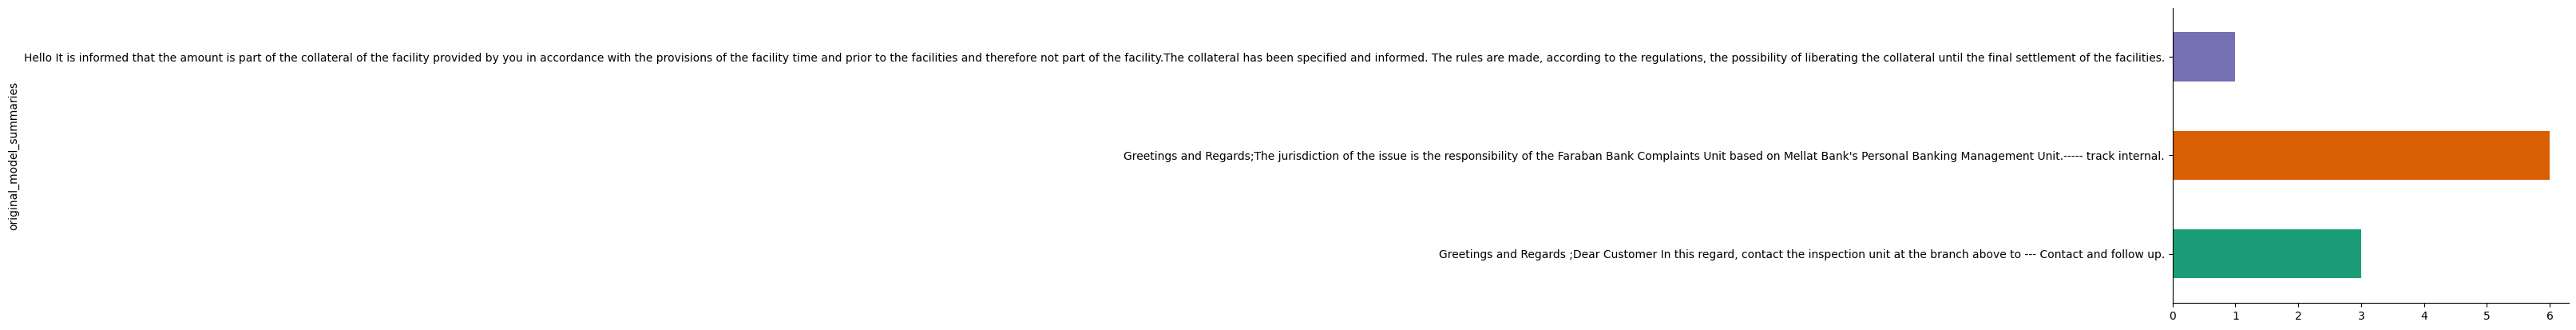

In [ ]:
# @title original_model_summaries

from matplotlib import pyplot as plt
import seaborn as sns
df2.groupby('original_model_summaries').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Assume 'peft_model' and 'tokenizer' have been previously loaded or defined

# Define the question prompt
question = 'may you help me'

prompt = f"""
Answer the following question.

{question}

Answer:
"""

# Tokenize the input prompt
inputs = tokenizer(prompt, return_tensors='pt').input_ids

# Generate the model's response
          #peft_model.generate(input_ids=input_ids.to(device), generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
outputs = peft_model.generate(
    input_ids = input_ids.to(device),
    generation_config = GenerationConfig(
        max_new_tokens=200  # You can adjust the number of tokens to generate as needed
    )
)

# Decode the output to get the answer
answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Print the question and the model's answer
print(f"Question: {question}")
print(f"Answer: {answer}")


Question: may you help me
Answer: I registered the Facility with the follow-up code in the reference section, which each time, such as non -compliance with the guarantor's income with the documentation, which was exactly the amount of the receipt, was even less declared, or the failure to load the last employment order.
